In [1]:
import requests
import pandas as pd
import numpy as np
import re
import sys, getopt
import csv
import pickle
import copy
import os
import math

pd.set_option('display.max_rows', 500)

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline  
import seaborn as sns
sns.set_style("darkgrid")

import umap
from sklearn.decomposition import TruncatedSVD as tsvd

def nearZeroVarDropAuto(df,thresh=0.99):
    vVal=df.var(axis=0).values
    cs=pd.Series(vVal).sort_values(ascending=False).cumsum()
    remove=cs[cs>cs.values[-1]*thresh].index.values
    return df.drop(df.columns[remove],axis=1)

%run SodaKick_download_functions.ipynb


import torch
from torch.utils.data import DataLoader, Dataset
from torch.optim import SGD, Adagrad, Adam, Adagrad
import torch.nn as nn
import torch.nn.functional as F

In [2]:
#from ray import tune
#from ray.tune import CLIReporter
#from ray.tune.schedulers import ASHAScheduler

from hyperopt import hp, tpe, fmin, Trials
from hyperopt import STATUS_OK, STATUS_FAIL
from hyperopt.pyll import scope

In [3]:
class EarlyStopping:

    """ Stops the training if loss doesn't improve after a given number of epochs. """

    def __init__(self, patience=3, epsilon=1e-5, keepBest=True, silent=True):

        """
        Args:
            patience (int): Number of epochs without change before stopping the learning (default 3).
            epsilon (float): Minimum change in loss to be considered for early stopping (default 1e-5).
            keepBest (bool): Keep track of the best model (memory consuming).
        """

        self.patience = patience
        self.epsilon = epsilon
        self.counter = 0
        
        self.bestScore = np.inf
     
        self.keepBest = keepBest 
        self.bestModel = None

        self.earlyStop = False
        self.silent = silent

    def __call__(self, loss, model):


        """ Evaluate the loss change between epochs and activates early stop if below epsilon.

        Args:
            loss (float): current loss.
            model (torch model): the current model.
        """

        if loss > self.bestScore - self.epsilon:

            self.counter += 1
            if not self.silent:
                print('EarlyStopping counter: {:d}/{:d}'.format(self.counter,self.patience))

            if self.counter >= self.patience:
                self.earlyStop = True

        else:   

            self.counter = 0
            self.bestScore = loss

            if self.keepBest:
                self.bestModel = copy.deepcopy(model)


In [4]:
class matchesDataset(Dataset):

    """ Extend pytorch Dataset class to include cleaning and training set creation, """
    
    def __init__(self, matches, results):

        self.matches = torch.tensor(matches, dtype=torch.float32)
        self.results = torch.tensor(results, dtype=torch.float32)

    def __len__(self):

        """ Returns the len of the training sample. """
        
        return len(self.matches)
        

    def __getitem__(self, index): 

        """ Returns a word, a context word and a list of negative words for training for a given index. 

        Args:
            index (int): index for the word selection.

        Returns:
            (string, string, list of strings): selected word, context word and a randomly drawn list 
                                               of negative words.

        """
        return self.matches[index], self.results[index]

In [109]:
#https://towardsdatascience.com/quirky-keras-custom-and-asymmetric-loss-functions-for-keras-in-r-a8b5271171fe
#weighted asimmetric square error, errors by going below the value (not seeing a goal when it's there) are weighted more

def WSE(output, target, a=1.5, b=.5):
    loss = torch.mean(a/(a+b)*torch.minimum(torch.zeros(output.shape[1]),output - target)**2+\
                      b/(a+b)*torch.maximum(torch.zeros(output.shape[1]),output - target)**2)      
    return loss

def WSEl1(output, target, a=1.5, b=.5):
    loss = torch.mean(a/(a+b)*torch.abs(torch.minimum(torch.zeros(output.shape[1]),output - target))+\
                      b/(a+b)*torch.abs(torch.maximum(torch.zeros(output.shape[1]),output - target)))      
    return loss

def WSE2(output, target, a=1.5, b=.5):
    loss = np.mean(a/(a+b)*np.minimum(np.zeros(output.shape[0]),output - target)**2+\
                      b/(a+b)*np.maximum(np.zeros(output.shape[0]),output - target)**2)      
    return loss

def WSEl12(output, target, a=1.25, b=.75):
    loss = np.mean(a/(a+b)*np.abs(np.minimum(np.zeros(output.shape[0]),output - target))+\
                      b/(a+b)*np.abs(np.maximum(np.zeros(output.shape[0]),output - target)))      
    return loss


def log_cosh_loss(y_pred: torch.Tensor, y_true: torch.Tensor) -> torch.Tensor:
    def _log_cosh(x: torch.Tensor) -> torch.Tensor:
        return x + torch.nn.functional.softplus(-2. * x) - math.log(2.0)
    return torch.mean(_log_cosh(y_pred - y_true))



def Wlog_cosh_loss(y_pred: torch.Tensor, y_true: torch.Tensor, a=1.5, b=.5) -> torch.Tensor:

    def _log_cosh(x: torch.Tensor) -> torch.Tensor:
        return x + torch.nn.functional.softplus(-2. * x) - math.log(2.0)   
        
    return torch.mean(a/(a+b)*_log_cosh(torch.minimum(torch.zeros(y_pred.shape[1]),y_pred - y_true))+\
                   b/(a+b)*_log_cosh(torch.maximum(torch.zeros(y_pred.shape[1]),y_pred - y_true)))


class LogCoshLoss(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(
        self, y_pred: torch.Tensor, y_true: torch.Tensor
    ) -> torch.Tensor:
        return log_cosh_loss(y_pred, y_true)

In [6]:
def normalize_mins(vec):
    for i in range(vec.shape[0]):
        vec[i][::8]=vec[i][::8]/90

def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

def NormalizeMatrix(data):   
    for i in range(data.shape[1]):
        data[:,i] = NormalizeData(data[:,i])

def norm_max(out):
    
    maxes=[]
    for i in range(int(out.shape[1]/8.0)):
        maxes.append(out[:,8*int(i):8*(int(i)+1)].max(axis=0))

        #maxes.append(out.max(axis=1)[8*int(i):8*(int(i)+1):8])
    denominator=np.tile(np.max(maxes,axis=0),int(out.shape[1]/8))
    return out/denominator, denominator 

with open(r'/Users/federico comitani/GitHub/sodakick/data/wainp_220303.pkl', 'rb') as pk:
    inp=pickle.load(pk)
with open(r'/Users/federico comitani/GitHub/sodakick/data/out_220303.pkl', 'rb') as pk:
    out=np.array(pickle.load(pk),dtype=float)
    
### skipping norm for now since it's already tsvd 
#NormalizeMatrix(inp)
#np.nan_to_num(inp, copy=False)

from sklearn import preprocessing

scaler = preprocessing.MinMaxScaler()
inp = scaler.fit_transform(inp)

#normalize_mins(out)
out, denominator= norm_max(out)

In [7]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
         inp[:50000], out[:50000], test_size=0.2, random_state=32)

In [8]:
class Net(nn.Module):
    
    #=nn.LeakyReLU()
    
    def __init__(self, num_layers, num_nodes_in, num_nodes, num_nodes_out, final_activation, batch_norm, dropout, activation):
        super(Net, self).__init__()
        
        self.fc = []
        self.lr = []
        self.bn = []
        self.dp = []
        self.act = activation
        self.fact = final_activation
        self.nl = num_layers
        self.batch_norm = batch_norm
        self.dropout = dropout
        
        power=0
        
        for i in range(self.nl):
            if i==0:
                self.fc.append(nn.Linear(int(num_nodes_in), int(num_nodes)))
            else:
                self.fc.append(nn.Linear(int(num_nodes), int(num_nodes)))
            self.lr.append(self.act)
            
            if self.batch_norm:
                self.bn.append(nn.BatchNorm1d(int(num_nodes)))

            if self.dropout>0.0:
                self.dp.append(nn.Dropout(dropout))
                
            power+=1
        
        self.oupt = nn.Linear(int(num_nodes), int(num_nodes_out))
    
    def reset_weights(self):

        """ Resets network weights according to chosen distribution. """

        for f in self.fc:
            nn.init.xavier_uniform_(f.weight, gain=np.sqrt(2/(1+0.01**2)))

            
    def forward(self, x):
        z = x
        for i in range(self.nl):
            
            z = self.fc[i](z)
            
            if self.batch_norm:
                z = self.bn[i](z)
            
            z = self.lr[i](z)
        
            if self.dropout>0.0:
                z = self.dp[i](z)
                
        if self.fact is not None:
            z = self.fact(z)
        
        z = self.oupt(z)
        
        return z
    
    def clp(self):
        with torch.no_grad():
            for i in range(self.nl):
                self.fc[i].weight.copy_ (self.fc[i].weight.data.clamp(min=0)) 
            self.oupt.weight.copy_ (self.oupt.weight.data.clamp(min=0))

In [9]:
def train(config, model=Net, silent=True, checkpoint_dir=None):
    
    if 'activation' not in config:
        config['activation']=nn.LeakyReLU()
    
    try:
        phases = ['train','val']

        #x_train, x_test, y_train, y_test = data[0], data[1], data[2], data[3]

        training_set = matchesDataset(x_train, y_train)
        trainBatch = torch.utils.data.DataLoader(training_set, batch_size=config['batch_size'], shuffle=config['shuffle'], num_workers=config['num_workers'])

        validation_set = matchesDataset(x_test, y_test)
        valBatch = torch.utils.data.DataLoader(validation_set, batch_size=config['batch_size'], shuffle=config['shuffle'], num_workers=config['num_workers'])

        earlStop = EarlyStopping(patience=config['patience'], keepBest=False)

        net = model(config['num_layers'], config['num_nodes_in'],  config['num_nodes'],
                    config['num_nodes_out'], config['final_activation'], config['batch_norm'], config['dropout'], config['activation'])

        net.reset_weights()

        device = "cpu"
        if torch.cuda.is_available():
            device = "cuda:0"
            if torch.cuda.device_count() > 1:
                net = nn.DataParallel(net)
        net.to(device)

        if checkpoint_dir:
            model_state, optimizer_state = torch.load(
                os.path.join(checkpoint_dir, "checkpoint"))
            net.load_state_dict(model_state)
            optimizer.load_state_dict(optimizer_state)

        if config['optim']=='adam':
            optimizer = Adam(net.parameters(), lr=config['lr'])
        elif config['optim']=='adagrad':
            optimizer = Adagrad(net.parameters(), lr=config['lr'])
        else:
            print('optim error')
            return


        losses=[[],[]]
        mses=[]
        diffs=[]
        exit=False

        #for epoch in tqdm(range(epochs), desc='Epoch'):
        for epoch in range(config['epochs']):

            if exit:
                break

            for phase in phases:
                if phase == 'train':
                    net.train(True) 

                    """ Run the training of the model. """    

                    losses_batch=[]
                    for batchNum, batch in enumerate(trainBatch):

                        x = batch[0]
                        y = batch[1]

                        """ Move batches to GPU if available. """

                        if torch.cuda.is_available():
                            x = x.cuda()
                            y = y.cuda()

                        """ Core of training. """

                        loss = config['loss_f'](net(x), y)

                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()
                        if config['clip']:
                            net.clp()

                        losses_batch.append(loss)

                    """ Early stop check. """

                    earlStop(loss, net)
                    finalepoch = epoch

                    if earlStop.earlyStop:

                        if not silent:
                            print('Limit loss improvement reached, stopping the training.')

                        exit=True 

                    #losses[0].append(torch.mean(torch.stack(losses_batch)).detach().cpu().numpy())
                else:
                    net.train(False)
                    net.eval()

                    val_loss=0
                    val_mse=0

                    losses_batch=[]
                    for batchNum, batch in enumerate(valBatch):

                        x = batch[0]
                        y = batch[1]

                        """ Move batches to GPU if available. """

                        if torch.cuda.is_available():
                            x = x.cuda()
                            y = y.cuda()

                        """ Core of training. """

                        optimizer.zero_grad()
                        output=net(x)
                        target=y
                        loss = config['loss_f'](output, target)

                        #losses_batch.append(loss)
                        val_loss+=loss.detach().numpy()
                        val_mse+=nn.MSELoss()(output, target).detach().numpy()

                    #losses[1].append(torch.mean(torch.stack(losses_batch)).detach().cpu().numpy())

                    #with tune.checkpoint_dir(epoch) as checkpoint_dir:
                    #    path = os.path.join(checkpoint_dir, "checkpoint")
                    #    torch.save((net.state_dict(), optimizer.state_dict()), path)

                    #tune.report(loss=(val_loss/batchNum), mse=(val_mse/batchNum))
                    #tune.report(loss=torch.mean(torch.stack(losses_batch)))

        return {'loss': (val_loss/batchNum), 'status': STATUS_OK , 'mse': (val_mse/batchNum)}
    
    except:
        
        return {'loss': np.nan, 'status': STATUS_FAIL, 'mse': np.nan}



In [10]:
def revert_output(output,multiplier=denominator,lineup=None):

    reframe=pd.DataFrame(output.reshape(48,8),
                 columns=['minutes','goals','assists','cards_yellow','cards_red','own_goals','goals_against','saves'])
    
    reframe[reframe<0] = 0
    if lineup is not None:
        reframe.index=lineup
        reframe.drop([x for x in reframe.index if x.startswith('dummy')], axis=0, inplace=True)
    
    
    #reframe['minutes']*=90
    reframe=reframe*denominator[:8]
    byteamframe=pd.concat([reframe.iloc[:24,:].sum(axis=0),reframe.iloc[24:,:].sum(axis=0)], axis=1).T
    
    return reframe, byteamframe[byteamframe.columns[1:]]

In [11]:
print('Baseline WSE: {:.3f}'.format(WSE2(np.array([0]*out[0].shape[0]),out[0])))
print('Baseline WSE l1: {:.3f}'.format(WSEl12(np.array([0]*out[0].shape[0]),out[0])))
print('Baseline MSE: {:.3f}'.format(WSE2(np.array([0]*out[0].shape[0]),out[0], a=1, b=1)))
print('Baseline MSE l1: {:.3f}'.format(WSEl12(np.array([0]*out[0].shape[0]),out[0], a=1, b=1)))

print(np.abs(out[1]-out[10]).sum())
print(np.abs(out[50]-out[60]).sum())
print(np.abs(out[100]-out[110]).sum())

Baseline WSE: 0.039
Baseline WSE l1: 0.052
Baseline MSE: 0.026
Baseline MSE l1: 0.035
36.36507936507937
24.09365079365079
34.76825396825397


In [12]:
def run_hopt(config, num_samples=10):#, gpus_per_trial=2):
    
    trials = Trials()
    result = fmin(
            fn=train,
            space=config,
            algo=tpe.suggest,
            max_evals=num_samples,
            trials=trials,
            show_progressbar=True),
            #early_stop_fn=10,
            #trials_save_file=None)
    
    
    return trials
    #return best_trained_model
    #test_acc = test_accuracy(best_trained_model, device)
    #print("Best trial test set accuracy: {}".format(test_acc))

In [17]:
 config = {
        "num_layers": hp.choice('num_layers', [1, 2, 3]),
        "num_nodes_in": inp.shape[1],
        "num_nodes": scope.int(hp.quniform('num_nodes', 20, 1000, q=10)),
        "num_nodes_out": out.shape[1], 
        "final_activation" : None,
        "activation": nn.LeakyReLU(),
        "clip": False, #hp.choice('clip',[True, False]),
        "batch_size": 32, #[16, 32, 64, 128]
        "loss_f": nn.MSELoss(),#WSE,#hp.choice('loss_f',[WSE, nn.MSELoss()]), #, nn.L1Loss()
        "optim": 'adam',#hp.choice('optim',['adam', 'adagrad']),
        "lr": 0.0001,#hp.choice('lr',[0.0001,0.001,.00001]),#hp.loguniform('lr', np.exp(np.log(1e-4)), np.exp(np.log(1e-1))),
        "batch_norm": False,#hp.choice('batch_norm',[True, False]),
        "dropout": 0.0,#hp.choice('dropout',[0.0,0.1,0.2,0.3]),#hp.sample_from(lambda _: np.random.uniform(low=0.0, high=.6)),
        "shuffle": True,
        "num_workers": 4,
        "patience": 5,
        "epochs": 50
    }
    
btm = run_hopt(config, num_samples=50)

100%|██████████| 50/50 [1:13:15<00:00, 87.91s/trial, best loss: 0.00707137417078066]   


In [21]:
results_df=[]

for trial in btm.trials:
    results_df.append([trial['result']['loss'],
    trial['result']['mse'],
    [1,2,3][trial['misc']['vals']["num_layers"][0]],
    #[inp.shape[1]][trial['misc']['vals']["num_nodes"][0]],
    trial['misc']['vals']["num_nodes"][0],
    #[out.shape[1]][trial['misc']['vals']["num_nodes_out"][0]],
    #[torch.tanh, None][trial['misc']['vals']["final_activation"][0]],
    #[True, False][trial['misc']['vals']["clip"][0]],
    #[16, 32, 64, 128][trial['misc']['vals']["batch_size"][0]],
    #trial['misc']['vals']["loss_f"][0],
    #['adam', 'adagrad'][trial['misc']['vals']["optim"][0]],
    #[0.0001,0.001,.01,.1][trial['misc']['vals']["lr"][0]],
    #[True, False][trial['misc']['vals']["batch_norm"][0]],
    #[0.0,0.1,0.2,0.3,0.4,0.5][trial['misc']['vals']["dropout"][0]],
    #True][trial['misc']['vals']["shuffle"][0]],
    #[4][trial['misc']['vals']["num_workers"][0]],
    #[10][trial['misc']['vals']["patience"][0]],
    #[50][trial['misc']['vals']["epochs"][0]]])
                       
    ])

 

results_df=pd.DataFrame(results_df,columns=['loss',
                                            'mse',
                                            'num_layers',
                                            'num_nodes',
                                            #'final_activation',
                                            #'clip', 
                                            #'optim', 
                                            #'lr',
                                            #'batch_norm',
                                            #'dropout'
                                            ]).sort_values('loss')

#results_df.to_hdf(r'/Users/federico comitani/GitHub/sodakick/data/hp_res1_mse_aavg.h5',key='df')

In [22]:
results_df.sort_values('loss')

,loss,mse,num_layers,num_nodes
21,0.007071,0.007071,1,1000.0
22,0.007104,0.007104,1,990.0
19,0.007110,0.007110,1,980.0
20,0.007124,0.007124,1,960.0
47,0.007144,0.007144,1,940.0
33,0.007160,0.007160,1,760.0
27,0.007177,0.007177,1,890.0
36,0.007182,0.007182,1,840.0
28,0.007187,0.007187,1,720.0
0,0.007191,0.007191,1,790.0


# full training with different losses, kfold

In [125]:
from tqdm import tqdm

def train_alone(config, data, model=Net, silent=True, checkpoint_dir=None):
    
    phases = ['train','val']
    
    x_train, y_train, x_test, y_test = data[0], data[1], data[2], data[3]

    training_set = matchesDataset(x_train, y_train)
    trainBatch = torch.utils.data.DataLoader(training_set, batch_size=config['batch_size'], shuffle=config['shuffle'], num_workers=config['num_workers'])

    validation_set = matchesDataset(x_test, y_test)
    valBatch = torch.utils.data.DataLoader(validation_set, batch_size=config['batch_size'], shuffle=config['shuffle'], num_workers=config['num_workers'])

    earlStop = EarlyStopping(patience=int(config['patience']), keepBest=True)

    net = model(config['num_layers'], config['num_nodes_in'],  config['num_nodes'],
                    config['num_nodes_out'], config['final_activation'], config['batch_norm'], config['dropout'], config['activation'])

    net.reset_weights()

    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if torch.cuda.device_count() > 1:
            net = nn.DataParallel(net)
    net.to(device)

    if checkpoint_dir:
        model_state, optimizer_state = torch.load(
            os.path.join(checkpoint_dir, "checkpoint"))
        net.load_state_dict(model_state)
        optimizer.load_state_dict(optimizer_state)

    if config['optim']=='adam':
        optimizer = Adam(net.parameters(), lr=config['lr'])
    elif config['optim']=='adagrad':
        optimizer = Adagrad(net.parameters(), lr=config['lr'])
    else:
        print('optim error')
        return


    losses=[[],[]]
    mses=[]
    diffs=[]
    exit=False

    for epoch in tqdm(range(config['epochs']), desc='Epoch'):
    #for epoch in range(config['epochs']):

        if exit:
            break

        for phase in phases:
            if phase == 'train':
                net.train(True) 

                """ Run the training of the model. """    

                losses_batch=[]
                mses_batch=[]
                for batchNum, batch in enumerate(trainBatch):

                    x = batch[0]
                    y = batch[1]

                    """ Move batches to GPU if available. """

                    if torch.cuda.is_available():
                        x = x.cuda()
                        y = y.cuda()

                    """ Core of training. """

                    loss = config['loss_f'](net(x), y)

                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                    if config['clip']:
                        net.clp()

                    losses_batch.append(loss)
                    #mses_batch.append(nn.MSELoss()(net(x), y).detach().numpy())


                """ Early stop check. """

                earlStop(loss, net)
                finalepoch = epoch

                if earlStop.earlyStop:

                    if not silent:
                        print('Limit loss improvement reached, stopping the training.')

                    exit=True 

                losses[0].append(torch.mean(torch.stack(losses_batch)).detach().cpu().numpy())
                #mse[0].append(torch.mean(torch.stack(mses_batch)).detach().cpu().numpy())

            else:
                net.train(False)
                net.eval()

                val_loss=0
                val_mse=0

                losses_batch=[]
                mses_batch=[]
                diff_batch=[]

                for batchNum, batch in enumerate(valBatch):

                    x = batch[0]
                    y = batch[1]

                    """ Move batches to GPU if available. """

                    if torch.cuda.is_available():
                        x = x.cuda()
                        y = y.cuda()

                    """ Core of training. """

                    optimizer.zero_grad()
                    output=net(x)
                    target=y
                    loss = config['loss_f'](output, target)

                    losses_batch.append(loss)
                    #mses_batch.append(nn.MSELoss()(output, target).detach().numpy())
                    
                    val_loss+=loss.detach().numpy()
                    #val_mse+=nn.MSELoss()(output, target).detach().numpy()
                    diff_batch.append(output-target)
                    
                losses[1].append(torch.mean(torch.stack(losses_batch)).detach().cpu().numpy())
                #mse[1].append(torch.mean(torch.stack(mses_batch)).detach().cpu().numpy())
                diffs.append(torch.mean(torch.cat(diff_batch, dim=0), dim=0).detach().cpu().numpy())
                
    return net, val_loss/batchNum, losses, diffs #mses

In [126]:
from sklearn.model_selection import KFold

def runKfold(data, model, config):
    
    kf = KFold(n_splits=5, shuffle=True)
    kf.get_n_splits(data[0])

    trlosses=[]
    losses=[]
    ec=[]
    mss=[]
    diffs=[]
    
    for train_index, test_index in kf.split(data[0]):
        x_train, y_train, x_test, y_test = data[0][train_index], data[1][train_index], data[0][test_index], data[1][test_index]

        net, val_loss, losses, df = train_alone(config, [x_train, y_train, x_test, y_test], model, silent=True, checkpoint_dir=None)
                
        trlosses.append(losses[0])
        losses.append(losses[1])
        diffs.append(df)

    errs=[np.mean([np.mean(x.reshape(-1, 48), axis=1) for x in diffs[y]], axis=0) for y in range(len(diffs))]
    meaerrs=np.mean(errs, axis=0)
    meastd=np.std(errs, axis=0)

    abserrs=[np.mean([np.mean(np.abs(x.reshape(-1, 48)), axis=1) for x in diffs[y]], axis=0) for y in range(len(diffs))]
    absmeaerrs=np.mean(abserrs, axis=0)
    absmeastd=np.std(abserrs, axis=0)
        
    print('KFold Result: {:.3f}+/-{:.3f}'.format(np.mean([np.mean(x) for x in losses]),np.std([np.mean(x) for x in losses])))
    return [trlosses,losses], net, [meaerrs, meastd], [absmeaerrs, absmeastd]

In [127]:
def tolerant_mean(arrs):
    lens = [len(i) for i in arrs]
    arr = np.ma.empty((np.max(lens),len(arrs)))
    arr.mask = True
    for idx, l in enumerate(arrs):
        arr[:len(l),idx] = l
    return arr.mean(axis = -1).data, arr.std(axis=-1).data

Epoch:  11%|█         | 11/100 [03:57<32:04, 21.62s/it]


KFold Result: 0.007+/-0.000
-0.10279441
0.07064319
0.04489231


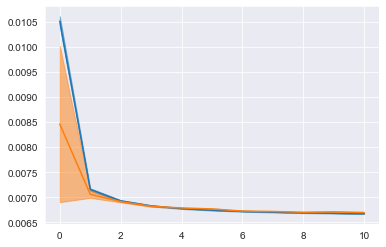

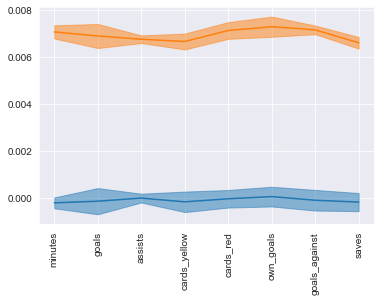

   goals  assists  cards_yellow  cards_red  own_goals  goals_against  saves
0      2        1             2          0          0              1      3
1      1        0             2          0          0              2      4
   goals  assists  cards_yellow  cards_red  own_goals  goals_against  saves
0      1        1             4          1          0              0      2
1      0        0             1          0          0              1      1


In [128]:
 config = {
        "num_layers": 1,
        "num_nodes_in": inp.shape[1],
        "num_nodes": inp.shape[1],
        "num_nodes_out": out.shape[1], 
        "final_activation" : None,
        "activation": nn.LeakyReLU(),
        "clip": False, #hp.choice('clip',[True, False]),
        "batch_size": 32, #[16, 32, 64, 128]
        "loss_f": nn.MSELoss(),#WSE,#hp.choice('loss_f',[WSE, nn.MSELoss()]), #, nn.L1Loss()
        "optim": 'adam',#hp.choice('optim',['adam', 'adagrad']),
        "lr": 0.0001,#hp.choice('lr',[0.0001,0.001,.00001]),#hp.loguniform('lr', np.exp(np.log(1e-4)), np.exp(np.log(1e-1))),
        "batch_norm": False,#hp.choice('batch_norm',[True, False]),
        "dropout": 0.0,#hp.choice('dropout',[0.0,0.1,0.2,0.3]),#hp.sample_from(lambda _: np.random.uniform(low=0.0, high=.6)),
        "shuffle": True,
        "num_workers": 4,
        "patience": 5,
        "epochs": 100
    }
    
lst1s, nt, errs, abserrs=runKfold([inp, out], Net, config)

print((nt(torch.Tensor(inp)).detach().cpu().numpy()[1]-nt(torch.Tensor(inp)).detach().cpu().numpy()[10]).sum())
print((nt(torch.Tensor(inp)).detach().cpu().numpy()[50]-nt(torch.Tensor(inp)).detach().cpu().numpy()[60]).sum())
print((nt(torch.Tensor(inp)).detach().cpu().numpy()[100]-nt(torch.Tensor(inp)).detach().cpu().numpy()[110]).sum())


#lsmea=[np.mean(lst1s[0],axis=0),np.mean(lst1s[1],axis=0)]
#lsstd=[np.std(lst1s[0],axis=0),np.std(lst1s[1],axis=0)]
lsmea=[[],[]]
lsstd=[[],[]]
lsmea[0],lsstd[0] = tolerant_mean(lst1s[0])
lsmea[1],lsstd[1] = tolerant_mean(lst1s[1])

plt.fill_between(np.arange(len(lsmea[0])),lsmea[0]+lsstd[0],lsmea[0]-lsstd[0], alpha=.5, color='#1f77b4')
plt.plot(lsmea[0], color='#1f77b4')
plt.fill_between(np.arange(len(lsmea[1])),lsmea[1]+lsstd[1],lsmea[1]-lsstd[1], alpha=.5, color='#ff7f0e')
plt.plot(lsmea[1], color='#ff7f0e')
plt.show()

plt.fill_between(np.arange(len(errs[0])),errs[0]+errs[1],errs[0]-errs[1], alpha=.5, color='#1f77b4')
plt.plot(errs[0], color='#1f77b4')
plt.fill_between(np.arange(len(abserrs[0])),abserrs[0]+abserrs[1],abserrs[0]-abserrs[1], alpha=.5, color='#ff7f0e')
plt.plot(abserrs[0], color='#ff7f0e')
plt.xticks(np.arange(len(errs[0])),['minutes','goals','assists','cards_yellow','cards_red','own_goals']+['goals_against','saves'], rotation=90)
plt.show()

pred=nt(torch.Tensor(inp)).detach().cpu().numpy()

i=1000
cats=['minutes','goals','assists','cards_yellow','cards_red','own_goals']+['goals_against','saves']

reframe, byteamframe = revert_output(pred[i])
print(byteamframe.astype(int))
reframe, byteamframe = revert_output(out[i])
print(byteamframe.astype(int))

Epoch:   8%|▊         | 8/100 [03:00<34:35, 22.56s/it]


KFold Result: 0.007+/-0.000
-0.34492278
-0.18872547
0.43927073


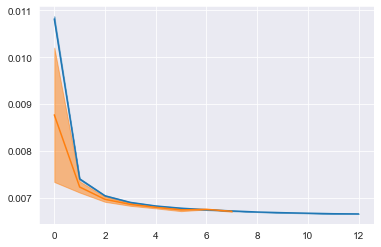

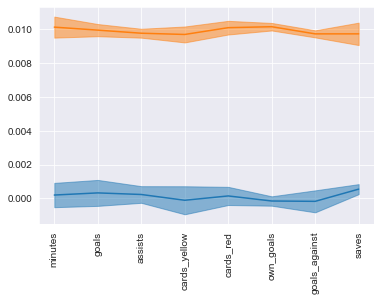

   goals  assists  cards_yellow  cards_red  own_goals  goals_against  saves
0      2        1             2          0          0              1      4
1      1        1             2          0          0              2      4
   goals  assists  cards_yellow  cards_red  own_goals  goals_against  saves
0      1        1             4          1          0              0      2
1      0        0             1          0          0              1      1


In [131]:
 config = {
        "num_layers": 1,
        "num_nodes_in": inp.shape[1],
        "num_nodes": inp.shape[1],
        "num_nodes_out": out.shape[1], 
        "final_activation" : None,
        "activation": nn.SELU(),
        "clip": False, #hp.choice('clip',[True, False]),
        "batch_size": 32, #[16, 32, 64, 128]
        "loss_f": nn.MSELoss(),#WSE,#hp.choice('loss_f',[WSE, nn.MSELoss()]), #, nn.L1Loss()
        "optim": 'adam',#hp.choice('optim',['adam', 'adagrad']),
        "lr": 0.0001,#hp.choice('lr',[0.0001,0.001,.00001]),#hp.loguniform('lr', np.exp(np.log(1e-4)), np.exp(np.log(1e-1))),
        "batch_norm": False,#hp.choice('batch_norm',[True, False]),
        "dropout": 0.0,#hp.choice('dropout',[0.0,0.1,0.2,0.3]),#hp.sample_from(lambda _: np.random.uniform(low=0.0, high=.6)),
        "shuffle": True,
        "num_workers": 4,
        "patience": 5,
        "epochs": 100
    }
    
lst1s, nt, errs, abserrs=runKfold([inp, out], Net, config)

print((nt(torch.Tensor(inp)).detach().cpu().numpy()[1]-nt(torch.Tensor(inp)).detach().cpu().numpy()[10]).sum())
print((nt(torch.Tensor(inp)).detach().cpu().numpy()[50]-nt(torch.Tensor(inp)).detach().cpu().numpy()[60]).sum())
print((nt(torch.Tensor(inp)).detach().cpu().numpy()[100]-nt(torch.Tensor(inp)).detach().cpu().numpy()[110]).sum())


#lsmea=[np.mean(lst1s[0],axis=0),np.mean(lst1s[1],axis=0)]
#lsstd=[np.std(lst1s[0],axis=0),np.std(lst1s[1],axis=0)]
lsmea=[[],[]]
lsstd=[[],[]]
lsmea[0],lsstd[0] = tolerant_mean(lst1s[0])
lsmea[1],lsstd[1] = tolerant_mean(lst1s[1])

plt.fill_between(np.arange(len(lsmea[0])),lsmea[0]+lsstd[0],lsmea[0]-lsstd[0], alpha=.5, color='#1f77b4')
plt.plot(lsmea[0], color='#1f77b4')
plt.fill_between(np.arange(len(lsmea[1])),lsmea[1]+lsstd[1],lsmea[1]-lsstd[1], alpha=.5, color='#ff7f0e')
plt.plot(lsmea[1], color='#ff7f0e')
plt.show()

plt.fill_between(np.arange(len(errs[0])),errs[0]+errs[1],errs[0]-errs[1], alpha=.5, color='#1f77b4')
plt.plot(errs[0], color='#1f77b4')
plt.fill_between(np.arange(len(abserrs[0])),abserrs[0]+abserrs[1],abserrs[0]-abserrs[1], alpha=.5, color='#ff7f0e')
plt.plot(abserrs[0], color='#ff7f0e')
plt.xticks(np.arange(len(errs[0])),['minutes','goals','assists','cards_yellow','cards_red','own_goals']+['goals_against','saves'], rotation=90)
plt.show()

pred=nt(torch.Tensor(inp)).detach().cpu().numpy()

i=1000
cats=['minutes','goals','assists','cards_yellow','cards_red','own_goals']+['goals_against','saves']

reframe, byteamframe = revert_output(pred[i])
print(byteamframe.astype(int))
reframe, byteamframe = revert_output(out[i])
print(byteamframe.astype(int))

Epoch:  10%|█         | 10/100 [04:51<43:47, 29.19s/it]


KFold Result: 0.004+/-0.000
0.44930792
0.6714673
-0.026535988


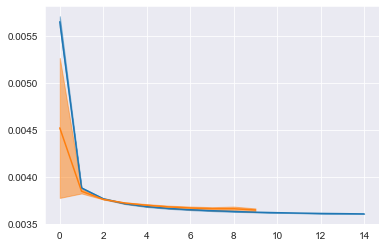

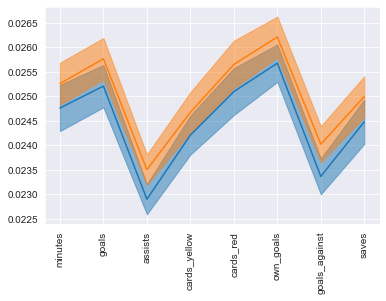

   goals  assists  cards_yellow  cards_red  own_goals  goals_against  saves
0      4        3             4          0          0              2      4
1      2        2             4          0          0              3      5
   goals  assists  cards_yellow  cards_red  own_goals  goals_against  saves
0      1        1             4          1          0              0      2
1      0        0             1          0          0              1      1


In [133]:
 config = {
        "num_layers": 1,
        "num_nodes_in": inp.shape[1],
        "num_nodes": inp.shape[1],
        "num_nodes_out": out.shape[1], 
        "final_activation" : None,
        "activation": nn.LeakyReLU(),
        "clip": False, #hp.choice('clip',[True, False]),
        "batch_size": 32, #[16, 32, 64, 128]
        "loss_f": WSE,#WSE,#hp.choice('loss_f',[WSE, nn.MSELoss()]), #, nn.L1Loss()
        "optim": 'adam',#hp.choice('optim',['adam', 'adagrad']),
        "lr": 0.0001,#hp.choice('lr',[0.0001,0.001,.00001]),#hp.loguniform('lr', np.exp(np.log(1e-4)), np.exp(np.log(1e-1))),
        "batch_norm": False,#hp.choice('batch_norm',[True, False]),
        "dropout": 0.0,#hp.choice('dropout',[0.0,0.1,0.2,0.3]),#hp.sample_from(lambda _: np.random.uniform(low=0.0, high=.6)),
        "shuffle": True,
        "num_workers": 4,
        "patience": 5,
        "epochs": 100
    }
    
lst1s, nt, errs, abserrs=runKfold([inp, out], Net, config)

print((nt(torch.Tensor(inp)).detach().cpu().numpy()[1]-nt(torch.Tensor(inp)).detach().cpu().numpy()[10]).sum())
print((nt(torch.Tensor(inp)).detach().cpu().numpy()[50]-nt(torch.Tensor(inp)).detach().cpu().numpy()[60]).sum())
print((nt(torch.Tensor(inp)).detach().cpu().numpy()[100]-nt(torch.Tensor(inp)).detach().cpu().numpy()[110]).sum())


#lsmea=[np.mean(lst1s[0],axis=0),np.mean(lst1s[1],axis=0)]
#lsstd=[np.std(lst1s[0],axis=0),np.std(lst1s[1],axis=0)]
lsmea=[[],[]]
lsstd=[[],[]]
lsmea[0],lsstd[0] = tolerant_mean(lst1s[0])
lsmea[1],lsstd[1] = tolerant_mean(lst1s[1])

plt.fill_between(np.arange(len(lsmea[0])),lsmea[0]+lsstd[0],lsmea[0]-lsstd[0], alpha=.5, color='#1f77b4')
plt.plot(lsmea[0], color='#1f77b4')
plt.fill_between(np.arange(len(lsmea[1])),lsmea[1]+lsstd[1],lsmea[1]-lsstd[1], alpha=.5, color='#ff7f0e')
plt.plot(lsmea[1], color='#ff7f0e')
plt.show()

plt.fill_between(np.arange(len(errs[0])),errs[0]+errs[1],errs[0]-errs[1], alpha=.5, color='#1f77b4')
plt.plot(errs[0], color='#1f77b4')
plt.fill_between(np.arange(len(abserrs[0])),abserrs[0]+abserrs[1],abserrs[0]-abserrs[1], alpha=.5, color='#ff7f0e')
plt.plot(abserrs[0], color='#ff7f0e')
plt.xticks(np.arange(len(errs[0])),['minutes','goals','assists','cards_yellow','cards_red','own_goals']+['goals_against','saves'], rotation=90)
plt.show()

pred=nt(torch.Tensor(inp)).detach().cpu().numpy()

i=1000
cats=['minutes','goals','assists','cards_yellow','cards_red','own_goals']+['goals_against','saves']

reframe, byteamframe = revert_output(pred[i])
print(byteamframe.astype(int))
reframe, byteamframe = revert_output(out[i])
print(byteamframe.astype(int))

Epoch:  12%|█▏        | 12/100 [05:33<40:42, 27.76s/it]


KFold Result: 0.003+/-0.000
0.37369418
0.5977886
0.30655575


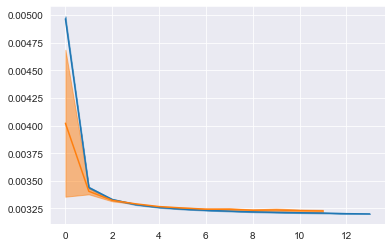

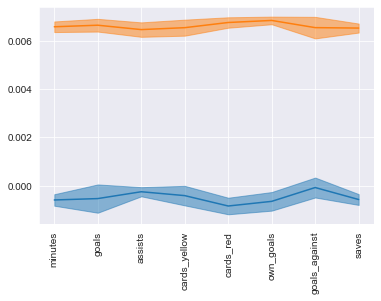

   goals  assists  cards_yellow  cards_red  own_goals  goals_against  saves
0      1        1             2          0          0              1      2
1      1        0             2          0          0              2      4
   goals  assists  cards_yellow  cards_red  own_goals  goals_against  saves
0      1        1             4          1          0              0      2
1      0        0             1          0          0              1      1


In [134]:
 config = {
        "num_layers": 1,
        "num_nodes_in": inp.shape[1],
        "num_nodes": inp.shape[1],
        "num_nodes_out": out.shape[1], 
        "final_activation" : None,
        "activation": nn.LeakyReLU(),
        "clip": False, #hp.choice('clip',[True, False]),
        "batch_size": 32, #[16, 32, 64, 128]
        "loss_f": log_cosh_loss,#WSE,#hp.choice('loss_f',[WSE, nn.MSELoss()]), #, nn.L1Loss()
        "optim": 'adam',#hp.choice('optim',['adam', 'adagrad']),
        "lr": 0.0001,#hp.choice('lr',[0.0001,0.001,.00001]),#hp.loguniform('lr', np.exp(np.log(1e-4)), np.exp(np.log(1e-1))),
        "batch_norm": False,#hp.choice('batch_norm',[True, False]),
        "dropout": 0.0,#hp.choice('dropout',[0.0,0.1,0.2,0.3]),#hp.sample_from(lambda _: np.random.uniform(low=0.0, high=.6)),
        "shuffle": True,
        "num_workers": 4,
        "patience": 5,
        "epochs": 100
    }
    
lst1s, nt, errs, abserrs=runKfold([inp, out], Net, config)

print((nt(torch.Tensor(inp)).detach().cpu().numpy()[1]-nt(torch.Tensor(inp)).detach().cpu().numpy()[10]).sum())
print((nt(torch.Tensor(inp)).detach().cpu().numpy()[50]-nt(torch.Tensor(inp)).detach().cpu().numpy()[60]).sum())
print((nt(torch.Tensor(inp)).detach().cpu().numpy()[100]-nt(torch.Tensor(inp)).detach().cpu().numpy()[110]).sum())


#lsmea=[np.mean(lst1s[0],axis=0),np.mean(lst1s[1],axis=0)]
#lsstd=[np.std(lst1s[0],axis=0),np.std(lst1s[1],axis=0)]
lsmea=[[],[]]
lsstd=[[],[]]
lsmea[0],lsstd[0] = tolerant_mean(lst1s[0])
lsmea[1],lsstd[1] = tolerant_mean(lst1s[1])

plt.fill_between(np.arange(len(lsmea[0])),lsmea[0]+lsstd[0],lsmea[0]-lsstd[0], alpha=.5, color='#1f77b4')
plt.plot(lsmea[0], color='#1f77b4')
plt.fill_between(np.arange(len(lsmea[1])),lsmea[1]+lsstd[1],lsmea[1]-lsstd[1], alpha=.5, color='#ff7f0e')
plt.plot(lsmea[1], color='#ff7f0e')
plt.show()

plt.fill_between(np.arange(len(errs[0])),errs[0]+errs[1],errs[0]-errs[1], alpha=.5, color='#1f77b4')
plt.plot(errs[0], color='#1f77b4')
plt.fill_between(np.arange(len(abserrs[0])),abserrs[0]+abserrs[1],abserrs[0]-abserrs[1], alpha=.5, color='#ff7f0e')
plt.plot(abserrs[0], color='#ff7f0e')
plt.xticks(np.arange(len(errs[0])),['minutes','goals','assists','cards_yellow','cards_red','own_goals']+['goals_against','saves'], rotation=90)
plt.show()

pred=nt(torch.Tensor(inp)).detach().cpu().numpy()

i=1000
cats=['minutes','goals','assists','cards_yellow','cards_red','own_goals']+['goals_against','saves']

reframe, byteamframe = revert_output(pred[i])
print(byteamframe.astype(int))
reframe, byteamframe = revert_output(out[i])
print(byteamframe.astype(int))

In [135]:
i=2000
cats=['minutes','goals','assists','cards_yellow','cards_red','own_goals']+['goals_against','saves']

reframe, byteamframe = revert_output(pred[i])
print(byteamframe.astype(int))
reframe, byteamframe = revert_output(out[i])
print(byteamframe.astype(int))

   goals  assists  cards_yellow  cards_red  own_goals  goals_against  saves
0      1        1             2          0          0              1      3
1      1        0             2          0          0              2      4
   goals  assists  cards_yellow  cards_red  own_goals  goals_against  saves
0      1        1             3          0          0              0      2
1      0        0             3          0          0              1      1


Epoch:  11%|█         | 11/100 [04:12<34:06, 23.00s/it]


KFold Result: 0.003+/-0.000
-0.092814684
0.40723443
0.5660565


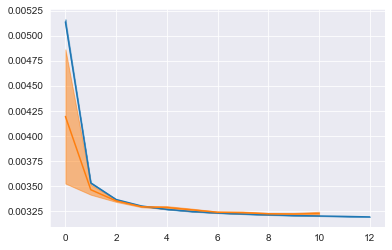

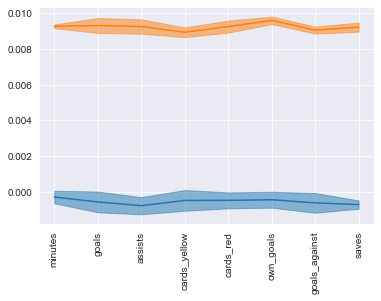

   goals  assists  cards_yellow  cards_red  own_goals  goals_against  saves
0      1        1             2          0          0              2      3
1      1        0             2          0          0              2      3
   goals  assists  cards_yellow  cards_red  own_goals  goals_against  saves
0      1        1             4          1          0              0      2
1      0        0             1          0          0              1      1


In [136]:
 config = {
        "num_layers": 1,
        "num_nodes_in": inp.shape[1],
        "num_nodes": inp.shape[1],
        "num_nodes_out": out.shape[1], 
        "final_activation" : None,
        "activation": nn.SELU(),
        "clip": False, #hp.choice('clip',[True, False]),
        "batch_size": 32, #[16, 32, 64, 128]
        "loss_f": log_cosh_loss,#WSE,#hp.choice('loss_f',[WSE, nn.MSELoss()]), #, nn.L1Loss()
        "optim": 'adam',#hp.choice('optim',['adam', 'adagrad']),
        "lr": 0.0001,#hp.choice('lr',[0.0001,0.001,.00001]),#hp.loguniform('lr', np.exp(np.log(1e-4)), np.exp(np.log(1e-1))),
        "batch_norm": False,#hp.choice('batch_norm',[True, False]),
        "dropout": 0.0,#hp.choice('dropout',[0.0,0.1,0.2,0.3]),#hp.sample_from(lambda _: np.random.uniform(low=0.0, high=.6)),
        "shuffle": True,
        "num_workers": 4,
        "patience": 5,
        "epochs": 100
    }
    
lst1s, nt, errs, abserrs=runKfold([inp, out], Net, config)

print((nt(torch.Tensor(inp)).detach().cpu().numpy()[1]-nt(torch.Tensor(inp)).detach().cpu().numpy()[10]).sum())
print((nt(torch.Tensor(inp)).detach().cpu().numpy()[50]-nt(torch.Tensor(inp)).detach().cpu().numpy()[60]).sum())
print((nt(torch.Tensor(inp)).detach().cpu().numpy()[100]-nt(torch.Tensor(inp)).detach().cpu().numpy()[110]).sum())


#lsmea=[np.mean(lst1s[0],axis=0),np.mean(lst1s[1],axis=0)]
#lsstd=[np.std(lst1s[0],axis=0),np.std(lst1s[1],axis=0)]
lsmea=[[],[]]
lsstd=[[],[]]
lsmea[0],lsstd[0] = tolerant_mean(lst1s[0])
lsmea[1],lsstd[1] = tolerant_mean(lst1s[1])

plt.fill_between(np.arange(len(lsmea[0])),lsmea[0]+lsstd[0],lsmea[0]-lsstd[0], alpha=.5, color='#1f77b4')
plt.plot(lsmea[0], color='#1f77b4')
plt.fill_between(np.arange(len(lsmea[1])),lsmea[1]+lsstd[1],lsmea[1]-lsstd[1], alpha=.5, color='#ff7f0e')
plt.plot(lsmea[1], color='#ff7f0e')
plt.show()

plt.fill_between(np.arange(len(errs[0])),errs[0]+errs[1],errs[0]-errs[1], alpha=.5, color='#1f77b4')
plt.plot(errs[0], color='#1f77b4')
plt.fill_between(np.arange(len(abserrs[0])),abserrs[0]+abserrs[1],abserrs[0]-abserrs[1], alpha=.5, color='#ff7f0e')
plt.plot(abserrs[0], color='#ff7f0e')
plt.xticks(np.arange(len(errs[0])),['minutes','goals','assists','cards_yellow','cards_red','own_goals']+['goals_against','saves'], rotation=90)
plt.show()

pred=nt(torch.Tensor(inp)).detach().cpu().numpy()

i=1000
cats=['minutes','goals','assists','cards_yellow','cards_red','own_goals']+['goals_against','saves']

reframe, byteamframe = revert_output(pred[i])
print(byteamframe.astype(int))
reframe, byteamframe = revert_output(out[i])
print(byteamframe.astype(int))

Epoch:   8%|▊         | 8/100 [04:08<47:35, 31.03s/it]


KFold Result: 0.003+/-0.000
-0.110388756
-0.4484551
-0.80023026


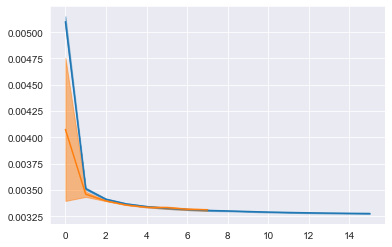

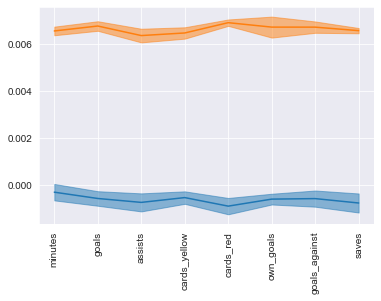

   goals  assists  cards_yellow  cards_red  own_goals  goals_against  saves
0      1        1             2          0          0              1      3
1      1        0             1          0          0              1      4
   goals  assists  cards_yellow  cards_red  own_goals  goals_against  saves
0      1        1             4          1          0              0      2
1      0        0             1          0          0              1      1


In [137]:
 config = {
        "num_layers": 2,
        "num_nodes_in": inp.shape[1],
        "num_nodes": inp.shape[1],
        "num_nodes_out": out.shape[1], 
        "final_activation" : None,
        "activation": nn.LeakyReLU(),
        "clip": False, #hp.choice('clip',[True, False]),
        "batch_size": 32, #[16, 32, 64, 128]
        "loss_f": log_cosh_loss,#WSE,#hp.choice('loss_f',[WSE, nn.MSELoss()]), #, nn.L1Loss()
        "optim": 'adam',#hp.choice('optim',['adam', 'adagrad']),
        "lr": 0.0001,#hp.choice('lr',[0.0001,0.001,.00001]),#hp.loguniform('lr', np.exp(np.log(1e-4)), np.exp(np.log(1e-1))),
        "batch_norm": False,#hp.choice('batch_norm',[True, False]),
        "dropout": 0.0,#hp.choice('dropout',[0.0,0.1,0.2,0.3]),#hp.sample_from(lambda _: np.random.uniform(low=0.0, high=.6)),
        "shuffle": True,
        "num_workers": 4,
        "patience": 5,
        "epochs": 100
    }
    
lst1s, nt, errs, abserrs=runKfold([inp, out], Net, config)

print((nt(torch.Tensor(inp)).detach().cpu().numpy()[1]-nt(torch.Tensor(inp)).detach().cpu().numpy()[10]).sum())
print((nt(torch.Tensor(inp)).detach().cpu().numpy()[50]-nt(torch.Tensor(inp)).detach().cpu().numpy()[60]).sum())
print((nt(torch.Tensor(inp)).detach().cpu().numpy()[100]-nt(torch.Tensor(inp)).detach().cpu().numpy()[110]).sum())


#lsmea=[np.mean(lst1s[0],axis=0),np.mean(lst1s[1],axis=0)]
#lsstd=[np.std(lst1s[0],axis=0),np.std(lst1s[1],axis=0)]
lsmea=[[],[]]
lsstd=[[],[]]
lsmea[0],lsstd[0] = tolerant_mean(lst1s[0])
lsmea[1],lsstd[1] = tolerant_mean(lst1s[1])

plt.fill_between(np.arange(len(lsmea[0])),lsmea[0]+lsstd[0],lsmea[0]-lsstd[0], alpha=.5, color='#1f77b4')
plt.plot(lsmea[0], color='#1f77b4')
plt.fill_between(np.arange(len(lsmea[1])),lsmea[1]+lsstd[1],lsmea[1]-lsstd[1], alpha=.5, color='#ff7f0e')
plt.plot(lsmea[1], color='#ff7f0e')
plt.show()

plt.fill_between(np.arange(len(errs[0])),errs[0]+errs[1],errs[0]-errs[1], alpha=.5, color='#1f77b4')
plt.plot(errs[0], color='#1f77b4')
plt.fill_between(np.arange(len(abserrs[0])),abserrs[0]+abserrs[1],abserrs[0]-abserrs[1], alpha=.5, color='#ff7f0e')
plt.plot(abserrs[0], color='#ff7f0e')
plt.xticks(np.arange(len(errs[0])),['minutes','goals','assists','cards_yellow','cards_red','own_goals']+['goals_against','saves'], rotation=90)
plt.show()

pred=nt(torch.Tensor(inp)).detach().cpu().numpy()

i=1000
cats=['minutes','goals','assists','cards_yellow','cards_red','own_goals']+['goals_against','saves']

reframe, byteamframe = revert_output(pred[i])
print(byteamframe.astype(int))
reframe, byteamframe = revert_output(out[i])
print(byteamframe.astype(int))

Epoch:  14%|█▍        | 14/100 [03:47<23:18, 16.26s/it]


KFold Result: 0.004+/-0.000
0.39788723
-0.12689471
0.43315363


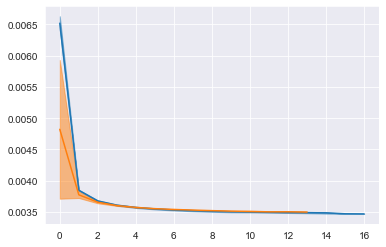

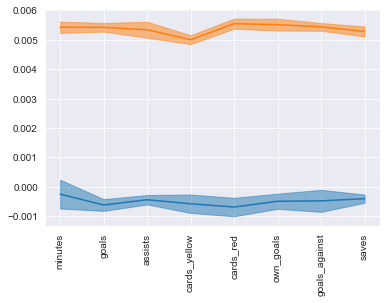

   goals  assists  cards_yellow  cards_red  own_goals  goals_against  saves
0      1        1             2          0          0              1      3
1      1        0             2          0          0              2      4
   goals  assists  cards_yellow  cards_red  own_goals  goals_against  saves
0      1        1             4          1          0              0      2
1      0        0             1          0          0              1      1


In [138]:
 config = {
        "num_layers": 2,
        "num_nodes_in": inp.shape[1],
        "num_nodes": inp.shape[1]/2,
        "num_nodes_out": out.shape[1], 
        "final_activation" : None,
        "activation": nn.LeakyReLU(),
        "clip": False, #hp.choice('clip',[True, False]),
        "batch_size": 32, #[16, 32, 64, 128]
        "loss_f": log_cosh_loss,#WSE,#hp.choice('loss_f',[WSE, nn.MSELoss()]), #, nn.L1Loss()
        "optim": 'adam',#hp.choice('optim',['adam', 'adagrad']),
        "lr": 0.0001,#hp.choice('lr',[0.0001,0.001,.00001]),#hp.loguniform('lr', np.exp(np.log(1e-4)), np.exp(np.log(1e-1))),
        "batch_norm": False,#hp.choice('batch_norm',[True, False]),
        "dropout": 0.0,#hp.choice('dropout',[0.0,0.1,0.2,0.3]),#hp.sample_from(lambda _: np.random.uniform(low=0.0, high=.6)),
        "shuffle": True,
        "num_workers": 4,
        "patience": 5,
        "epochs": 100
    }
    
lst1s, nt, errs, abserrs=runKfold([inp, out], Net, config)

print((nt(torch.Tensor(inp)).detach().cpu().numpy()[1]-nt(torch.Tensor(inp)).detach().cpu().numpy()[10]).sum())
print((nt(torch.Tensor(inp)).detach().cpu().numpy()[50]-nt(torch.Tensor(inp)).detach().cpu().numpy()[60]).sum())
print((nt(torch.Tensor(inp)).detach().cpu().numpy()[100]-nt(torch.Tensor(inp)).detach().cpu().numpy()[110]).sum())


#lsmea=[np.mean(lst1s[0],axis=0),np.mean(lst1s[1],axis=0)]
#lsstd=[np.std(lst1s[0],axis=0),np.std(lst1s[1],axis=0)]
lsmea=[[],[]]
lsstd=[[],[]]
lsmea[0],lsstd[0] = tolerant_mean(lst1s[0])
lsmea[1],lsstd[1] = tolerant_mean(lst1s[1])

plt.fill_between(np.arange(len(lsmea[0])),lsmea[0]+lsstd[0],lsmea[0]-lsstd[0], alpha=.5, color='#1f77b4')
plt.plot(lsmea[0], color='#1f77b4')
plt.fill_between(np.arange(len(lsmea[1])),lsmea[1]+lsstd[1],lsmea[1]-lsstd[1], alpha=.5, color='#ff7f0e')
plt.plot(lsmea[1], color='#ff7f0e')
plt.show()

plt.fill_between(np.arange(len(errs[0])),errs[0]+errs[1],errs[0]-errs[1], alpha=.5, color='#1f77b4')
plt.plot(errs[0], color='#1f77b4')
plt.fill_between(np.arange(len(abserrs[0])),abserrs[0]+abserrs[1],abserrs[0]-abserrs[1], alpha=.5, color='#ff7f0e')
plt.plot(abserrs[0], color='#ff7f0e')
plt.xticks(np.arange(len(errs[0])),['minutes','goals','assists','cards_yellow','cards_red','own_goals']+['goals_against','saves'], rotation=90)
plt.show()

pred=nt(torch.Tensor(inp)).detach().cpu().numpy()

i=1000
cats=['minutes','goals','assists','cards_yellow','cards_red','own_goals']+['goals_against','saves']

reframe, byteamframe = revert_output(pred[i])
print(byteamframe.astype(int))
reframe, byteamframe = revert_output(out[i])
print(byteamframe.astype(int))

Epoch:  20%|██        | 20/100 [04:53<19:34, 14.68s/it]


KFold Result: 0.004+/-0.000
-1.2313528
-0.51816154
0.28424358


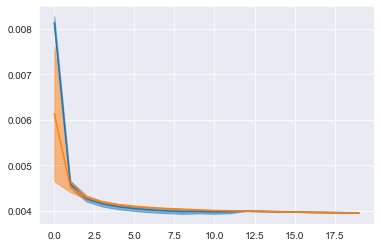

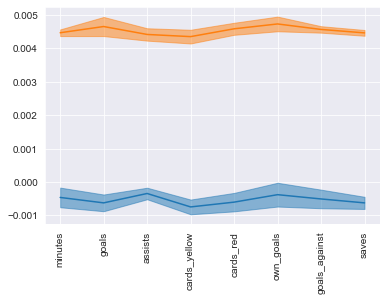

   goals  assists  cards_yellow  cards_red  own_goals  goals_against  saves
0      1        0             1          0          0              1      3
1      1        0             2          0          0              2      3
   goals  assists  cards_yellow  cards_red  own_goals  goals_against  saves
0      1        1             4          1          0              0      2
1      0        0             1          0          0              1      1


In [139]:
 config = {
        "num_layers": 3,
        "num_nodes_in": inp.shape[1],
        "num_nodes": inp.shape[1]/3,
        "num_nodes_out": out.shape[1], 
        "final_activation" : None,
        "activation": nn.LeakyReLU(),
        "clip": False, #hp.choice('clip',[True, False]),
        "batch_size": 32, #[16, 32, 64, 128]
        "loss_f": log_cosh_loss,#WSE,#hp.choice('loss_f',[WSE, nn.MSELoss()]), #, nn.L1Loss()
        "optim": 'adam',#hp.choice('optim',['adam', 'adagrad']),
        "lr": 0.0001,#hp.choice('lr',[0.0001,0.001,.00001]),#hp.loguniform('lr', np.exp(np.log(1e-4)), np.exp(np.log(1e-1))),
        "batch_norm": False,#hp.choice('batch_norm',[True, False]),
        "dropout": 0.0,#hp.choice('dropout',[0.0,0.1,0.2,0.3]),#hp.sample_from(lambda _: np.random.uniform(low=0.0, high=.6)),
        "shuffle": True,
        "num_workers": 4,
        "patience": 5,
        "epochs": 100
    }
    
lst1s, nt, errs, abserrs=runKfold([inp, out], Net, config)

print((nt(torch.Tensor(inp)).detach().cpu().numpy()[1]-nt(torch.Tensor(inp)).detach().cpu().numpy()[10]).sum())
print((nt(torch.Tensor(inp)).detach().cpu().numpy()[50]-nt(torch.Tensor(inp)).detach().cpu().numpy()[60]).sum())
print((nt(torch.Tensor(inp)).detach().cpu().numpy()[100]-nt(torch.Tensor(inp)).detach().cpu().numpy()[110]).sum())


#lsmea=[np.mean(lst1s[0],axis=0),np.mean(lst1s[1],axis=0)]
#lsstd=[np.std(lst1s[0],axis=0),np.std(lst1s[1],axis=0)]
lsmea=[[],[]]
lsstd=[[],[]]
lsmea[0],lsstd[0] = tolerant_mean(lst1s[0])
lsmea[1],lsstd[1] = tolerant_mean(lst1s[1])

plt.fill_between(np.arange(len(lsmea[0])),lsmea[0]+lsstd[0],lsmea[0]-lsstd[0], alpha=.5, color='#1f77b4')
plt.plot(lsmea[0], color='#1f77b4')
plt.fill_between(np.arange(len(lsmea[1])),lsmea[1]+lsstd[1],lsmea[1]-lsstd[1], alpha=.5, color='#ff7f0e')
plt.plot(lsmea[1], color='#ff7f0e')
plt.show()

plt.fill_between(np.arange(len(errs[0])),errs[0]+errs[1],errs[0]-errs[1], alpha=.5, color='#1f77b4')
plt.plot(errs[0], color='#1f77b4')
plt.fill_between(np.arange(len(abserrs[0])),abserrs[0]+abserrs[1],abserrs[0]-abserrs[1], alpha=.5, color='#ff7f0e')
plt.plot(abserrs[0], color='#ff7f0e')
plt.xticks(np.arange(len(errs[0])),['minutes','goals','assists','cards_yellow','cards_red','own_goals']+['goals_against','saves'], rotation=90)
plt.show()

pred=nt(torch.Tensor(inp)).detach().cpu().numpy()

i=1000
cats=['minutes','goals','assists','cards_yellow','cards_red','own_goals']+['goals_against','saves']

reframe, byteamframe = revert_output(pred[i])
print(byteamframe.astype(int))
reframe, byteamframe = revert_output(out[i])
print(byteamframe.astype(int))

In [140]:
i=10000
cats=['minutes','goals','assists','cards_yellow','cards_red','own_goals']+['goals_against','saves']

reframe, byteamframe = revert_output(pred[i])
print(byteamframe.astype(int))
reframe, byteamframe = revert_output(out[i])
print(byteamframe.astype(int))

   goals  assists  cards_yellow  cards_red  own_goals  goals_against  saves
0      1        1             1          0          0              1      3
1      1        0             2          0          0              2      4
   goals  assists  cards_yellow  cards_red  own_goals  goals_against  saves
0      3        2             2          0          0              0      1
1      0        0             0          0          0              3      2


Epoch:  10%|█         | 10/100 [03:46<33:55, 22.62s/it]


KFold Result: 0.029+/-0.001
0.014719963
-0.046955824
-0.4004686


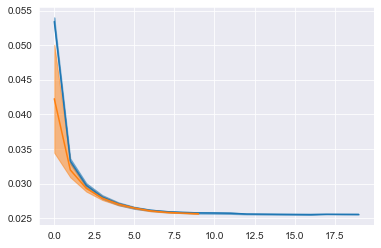

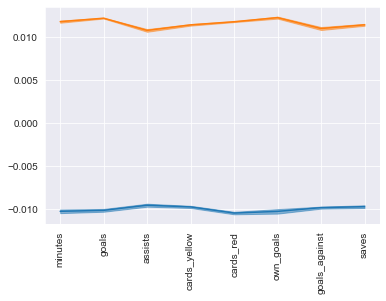

   goals  assists  cards_yellow  cards_red  own_goals  goals_against  saves
0      0        0             0          0          0              0      1
1      0        0             0          0          0              1      1
   goals  assists  cards_yellow  cards_red  own_goals  goals_against  saves
0      1        1             4          1          0              0      2
1      0        0             1          0          0              1      1


In [141]:
 config = {
        "num_layers": 2,
        "num_nodes_in": inp.shape[1],
        "num_nodes": inp.shape[1]/2,
        "num_nodes_out": out.shape[1], 
        "final_activation" : None,
        "activation": nn.LeakyReLU(),
        "clip": False, #hp.choice('clip',[True, False]),
        "batch_size": 32, #[16, 32, 64, 128]
        "loss_f": nn.L1Loss(),#WSE,#hp.choice('loss_f',[WSE, nn.MSELoss()]), #, 
        "optim": 'adam',#hp.choice('optim',['adam', 'adagrad']),
        "lr": 0.0001,#hp.choice('lr',[0.0001,0.001,.00001]),#hp.loguniform('lr', np.exp(np.log(1e-4)), np.exp(np.log(1e-1))),
        "batch_norm": False,#hp.choice('batch_norm',[True, False]),
        "dropout": 0.0,#hp.choice('dropout',[0.0,0.1,0.2,0.3]),#hp.sample_from(lambda _: np.random.uniform(low=0.0, high=.6)),
        "shuffle": True,
        "num_workers": 4,
        "patience": 5,
        "epochs": 100
    }
    
lst1s, nt, errs, abserrs=runKfold([inp, out], Net, config)

print((nt(torch.Tensor(inp)).detach().cpu().numpy()[1]-nt(torch.Tensor(inp)).detach().cpu().numpy()[10]).sum())
print((nt(torch.Tensor(inp)).detach().cpu().numpy()[50]-nt(torch.Tensor(inp)).detach().cpu().numpy()[60]).sum())
print((nt(torch.Tensor(inp)).detach().cpu().numpy()[100]-nt(torch.Tensor(inp)).detach().cpu().numpy()[110]).sum())


#lsmea=[np.mean(lst1s[0],axis=0),np.mean(lst1s[1],axis=0)]
#lsstd=[np.std(lst1s[0],axis=0),np.std(lst1s[1],axis=0)]
lsmea=[[],[]]
lsstd=[[],[]]
lsmea[0],lsstd[0] = tolerant_mean(lst1s[0])
lsmea[1],lsstd[1] = tolerant_mean(lst1s[1])

plt.fill_between(np.arange(len(lsmea[0])),lsmea[0]+lsstd[0],lsmea[0]-lsstd[0], alpha=.5, color='#1f77b4')
plt.plot(lsmea[0], color='#1f77b4')
plt.fill_between(np.arange(len(lsmea[1])),lsmea[1]+lsstd[1],lsmea[1]-lsstd[1], alpha=.5, color='#ff7f0e')
plt.plot(lsmea[1], color='#ff7f0e')
plt.show()

plt.fill_between(np.arange(len(errs[0])),errs[0]+errs[1],errs[0]-errs[1], alpha=.5, color='#1f77b4')
plt.plot(errs[0], color='#1f77b4')
plt.fill_between(np.arange(len(abserrs[0])),abserrs[0]+abserrs[1],abserrs[0]-abserrs[1], alpha=.5, color='#ff7f0e')
plt.plot(abserrs[0], color='#ff7f0e')
plt.xticks(np.arange(len(errs[0])),['minutes','goals','assists','cards_yellow','cards_red','own_goals']+['goals_against','saves'], rotation=90)
plt.show()

pred=nt(torch.Tensor(inp)).detach().cpu().numpy()

i=1000
cats=['minutes','goals','assists','cards_yellow','cards_red','own_goals']+['goals_against','saves']

reframe, byteamframe = revert_output(pred[i])
print(byteamframe.astype(int))
reframe, byteamframe = revert_output(out[i])
print(byteamframe.astype(int))

Epoch:  13%|█▎        | 13/100 [04:52<32:36, 22.48s/it]


KFold Result: 0.015+/-0.000
-0.8464682
-0.5909035
-0.013227701


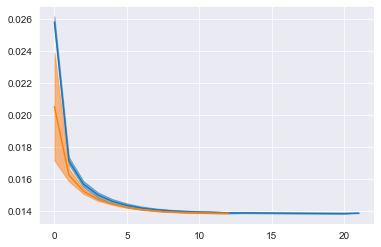

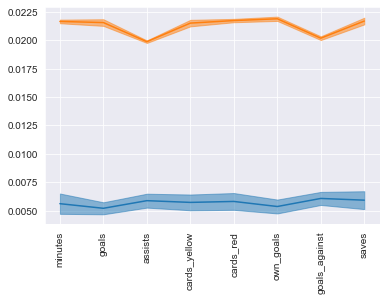

   goals  assists  cards_yellow  cards_red  own_goals  goals_against  saves
0      0        0             0          0          0              2      4
1      0        0             0          0          0              2      5
   goals  assists  cards_yellow  cards_red  own_goals  goals_against  saves
0      1        1             4          1          0              0      2
1      0        0             1          0          0              1      1


In [142]:
 config = {
        "num_layers": 2,
        "num_nodes_in": inp.shape[1],
        "num_nodes": inp.shape[1]/2,
        "num_nodes_out": out.shape[1], 
        "final_activation" : None,
        "activation": nn.LeakyReLU(),
        "clip": False, #hp.choice('clip',[True, False]),
        "batch_size": 32, #[16, 32, 64, 128]
        "loss_f": WSEl1,#WSE,#hp.choice('loss_f',[WSE, nn.MSELoss()]), #, 
        "optim": 'adam',#hp.choice('optim',['adam', 'adagrad']),
        "lr": 0.0001,#hp.choice('lr',[0.0001,0.001,.00001]),#hp.loguniform('lr', np.exp(np.log(1e-4)), np.exp(np.log(1e-1))),
        "batch_norm": False,#hp.choice('batch_norm',[True, False]),
        "dropout": 0.0,#hp.choice('dropout',[0.0,0.1,0.2,0.3]),#hp.sample_from(lambda _: np.random.uniform(low=0.0, high=.6)),
        "shuffle": True,
        "num_workers": 4,
        "patience": 5,
        "epochs": 100
    }
    
lst1s, nt, errs, abserrs=runKfold([inp, out], Net, config)

print((nt(torch.Tensor(inp)).detach().cpu().numpy()[1]-nt(torch.Tensor(inp)).detach().cpu().numpy()[10]).sum())
print((nt(torch.Tensor(inp)).detach().cpu().numpy()[50]-nt(torch.Tensor(inp)).detach().cpu().numpy()[60]).sum())
print((nt(torch.Tensor(inp)).detach().cpu().numpy()[100]-nt(torch.Tensor(inp)).detach().cpu().numpy()[110]).sum())


#lsmea=[np.mean(lst1s[0],axis=0),np.mean(lst1s[1],axis=0)]
#lsstd=[np.std(lst1s[0],axis=0),np.std(lst1s[1],axis=0)]
lsmea=[[],[]]
lsstd=[[],[]]
lsmea[0],lsstd[0] = tolerant_mean(lst1s[0])
lsmea[1],lsstd[1] = tolerant_mean(lst1s[1])

plt.fill_between(np.arange(len(lsmea[0])),lsmea[0]+lsstd[0],lsmea[0]-lsstd[0], alpha=.5, color='#1f77b4')
plt.plot(lsmea[0], color='#1f77b4')
plt.fill_between(np.arange(len(lsmea[1])),lsmea[1]+lsstd[1],lsmea[1]-lsstd[1], alpha=.5, color='#ff7f0e')
plt.plot(lsmea[1], color='#ff7f0e')
plt.show()

plt.fill_between(np.arange(len(errs[0])),errs[0]+errs[1],errs[0]-errs[1], alpha=.5, color='#1f77b4')
plt.plot(errs[0], color='#1f77b4')
plt.fill_between(np.arange(len(abserrs[0])),abserrs[0]+abserrs[1],abserrs[0]-abserrs[1], alpha=.5, color='#ff7f0e')
plt.plot(abserrs[0], color='#ff7f0e')
plt.xticks(np.arange(len(errs[0])),['minutes','goals','assists','cards_yellow','cards_red','own_goals']+['goals_against','saves'], rotation=90)
plt.show()

pred=nt(torch.Tensor(inp)).detach().cpu().numpy()

i=1000
cats=['minutes','goals','assists','cards_yellow','cards_red','own_goals']+['goals_against','saves']

reframe, byteamframe = revert_output(pred[i])
print(byteamframe.astype(int))
reframe, byteamframe = revert_output(out[i])
print(byteamframe.astype(int))

Epoch:  10%|█         | 10/100 [04:07<37:04, 24.72s/it]


KFold Result: 0.002+/-0.000
2.171926
-0.55798244
0.11224532


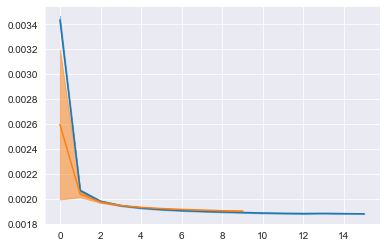

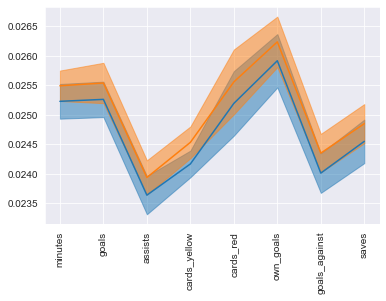

   goals  assists  cards_yellow  cards_red  own_goals  goals_against  saves
0      5        3             5          0          0              2      5
1      2        1             5          0          0              3      6
   goals  assists  cards_yellow  cards_red  own_goals  goals_against  saves
0      1        1             4          1          0              0      2
1      0        0             1          0          0              1      1


In [143]:
 config = {
        "num_layers": 2,
        "num_nodes_in": inp.shape[1],
        "num_nodes": inp.shape[1]/2,
        "num_nodes_out": out.shape[1], 
        "final_activation" : None,
        "activation": nn.LeakyReLU(),
        "clip": False, #hp.choice('clip',[True, False]),
        "batch_size": 32, #[16, 32, 64, 128]
        "loss_f": Wlog_cosh_loss,#WSE,#hp.choice('loss_f',[WSE, nn.MSELoss()]), #, 
        "optim": 'adam',#hp.choice('optim',['adam', 'adagrad']),
        "lr": 0.0001,#hp.choice('lr',[0.0001,0.001,.00001]),#hp.loguniform('lr', np.exp(np.log(1e-4)), np.exp(np.log(1e-1))),
        "batch_norm": False,#hp.choice('batch_norm',[True, False]),
        "dropout": 0.0,#hp.choice('dropout',[0.0,0.1,0.2,0.3]),#hp.sample_from(lambda _: np.random.uniform(low=0.0, high=.6)),
        "shuffle": True,
        "num_workers": 4,
        "patience": 5,
        "epochs": 100
    }
    
lst1s, nt, errs, abserrs=runKfold([inp, out], Net, config)

print((nt(torch.Tensor(inp)).detach().cpu().numpy()[1]-nt(torch.Tensor(inp)).detach().cpu().numpy()[10]).sum())
print((nt(torch.Tensor(inp)).detach().cpu().numpy()[50]-nt(torch.Tensor(inp)).detach().cpu().numpy()[60]).sum())
print((nt(torch.Tensor(inp)).detach().cpu().numpy()[100]-nt(torch.Tensor(inp)).detach().cpu().numpy()[110]).sum())


#lsmea=[np.mean(lst1s[0],axis=0),np.mean(lst1s[1],axis=0)]
#lsstd=[np.std(lst1s[0],axis=0),np.std(lst1s[1],axis=0)]
lsmea=[[],[]]
lsstd=[[],[]]
lsmea[0],lsstd[0] = tolerant_mean(lst1s[0])
lsmea[1],lsstd[1] = tolerant_mean(lst1s[1])

plt.fill_between(np.arange(len(lsmea[0])),lsmea[0]+lsstd[0],lsmea[0]-lsstd[0], alpha=.5, color='#1f77b4')
plt.plot(lsmea[0], color='#1f77b4')
plt.fill_between(np.arange(len(lsmea[1])),lsmea[1]+lsstd[1],lsmea[1]-lsstd[1], alpha=.5, color='#ff7f0e')
plt.plot(lsmea[1], color='#ff7f0e')
plt.show()

plt.fill_between(np.arange(len(errs[0])),errs[0]+errs[1],errs[0]-errs[1], alpha=.5, color='#1f77b4')
plt.plot(errs[0], color='#1f77b4')
plt.fill_between(np.arange(len(abserrs[0])),abserrs[0]+abserrs[1],abserrs[0]-abserrs[1], alpha=.5, color='#ff7f0e')
plt.plot(abserrs[0], color='#ff7f0e')
plt.xticks(np.arange(len(errs[0])),['minutes','goals','assists','cards_yellow','cards_red','own_goals']+['goals_against','saves'], rotation=90)
plt.show()

pred=nt(torch.Tensor(inp)).detach().cpu().numpy()

i=1000
cats=['minutes','goals','assists','cards_yellow','cards_red','own_goals']+['goals_against','saves']

reframe, byteamframe = revert_output(pred[i])
print(byteamframe.astype(int))
reframe, byteamframe = revert_output(out[i])
print(byteamframe.astype(int))

Epoch:  20%|██        | 20/100 [04:57<19:51, 14.90s/it]


KFold Result: 0.005+/-0.000
0.6085167
-0.9347141
-0.6097206


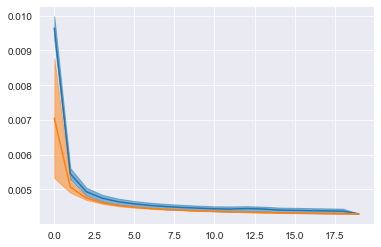

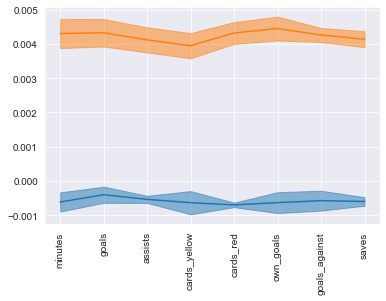

   goals  assists  cards_yellow  cards_red  own_goals  goals_against  saves
0      1        1             1          0          0              1      3
1      0        0             2          0          0              2      4
   goals  assists  cards_yellow  cards_red  own_goals  goals_against  saves
0      1        1             4          1          0              0      2
1      0        0             1          0          0              1      1


In [144]:
 config = {
        "num_layers": 4,
        "num_nodes_in": inp.shape[1],
        "num_nodes": inp.shape[1]/4,
        "num_nodes_out": out.shape[1], 
        "final_activation" : None,
        "activation": nn.LeakyReLU(),
        "clip": False, #hp.choice('clip',[True, False]),
        "batch_size": 32, #[16, 32, 64, 128]
        "loss_f": log_cosh_loss,#WSE,#hp.choice('loss_f',[WSE, nn.MSELoss()]), #, nn.L1Loss()
        "optim": 'adam',#hp.choice('optim',['adam', 'adagrad']),
        "lr": 0.0001,#hp.choice('lr',[0.0001,0.001,.00001]),#hp.loguniform('lr', np.exp(np.log(1e-4)), np.exp(np.log(1e-1))),
        "batch_norm": False,#hp.choice('batch_norm',[True, False]),
        "dropout": 0.0,#hp.choice('dropout',[0.0,0.1,0.2,0.3]),#hp.sample_from(lambda _: np.random.uniform(low=0.0, high=.6)),
        "shuffle": True,
        "num_workers": 4,
        "patience": 5,
        "epochs": 100
    }
    
lst1s, nt, errs, abserrs=runKfold([inp, out], Net, config)

print((nt(torch.Tensor(inp)).detach().cpu().numpy()[1]-nt(torch.Tensor(inp)).detach().cpu().numpy()[10]).sum())
print((nt(torch.Tensor(inp)).detach().cpu().numpy()[50]-nt(torch.Tensor(inp)).detach().cpu().numpy()[60]).sum())
print((nt(torch.Tensor(inp)).detach().cpu().numpy()[100]-nt(torch.Tensor(inp)).detach().cpu().numpy()[110]).sum())


#lsmea=[np.mean(lst1s[0],axis=0),np.mean(lst1s[1],axis=0)]
#lsstd=[np.std(lst1s[0],axis=0),np.std(lst1s[1],axis=0)]
lsmea=[[],[]]
lsstd=[[],[]]
lsmea[0],lsstd[0] = tolerant_mean(lst1s[0])
lsmea[1],lsstd[1] = tolerant_mean(lst1s[1])

plt.fill_between(np.arange(len(lsmea[0])),lsmea[0]+lsstd[0],lsmea[0]-lsstd[0], alpha=.5, color='#1f77b4')
plt.plot(lsmea[0], color='#1f77b4')
plt.fill_between(np.arange(len(lsmea[1])),lsmea[1]+lsstd[1],lsmea[1]-lsstd[1], alpha=.5, color='#ff7f0e')
plt.plot(lsmea[1], color='#ff7f0e')
plt.show()

plt.fill_between(np.arange(len(errs[0])),errs[0]+errs[1],errs[0]-errs[1], alpha=.5, color='#1f77b4')
plt.plot(errs[0], color='#1f77b4')
plt.fill_between(np.arange(len(abserrs[0])),abserrs[0]+abserrs[1],abserrs[0]-abserrs[1], alpha=.5, color='#ff7f0e')
plt.plot(abserrs[0], color='#ff7f0e')
plt.xticks(np.arange(len(errs[0])),['minutes','goals','assists','cards_yellow','cards_red','own_goals']+['goals_against','saves'], rotation=90)
plt.show()

pred=nt(torch.Tensor(inp)).detach().cpu().numpy()

i=1000
cats=['minutes','goals','assists','cards_yellow','cards_red','own_goals']+['goals_against','saves']

reframe, byteamframe = revert_output(pred[i])
print(byteamframe.astype(int))
reframe, byteamframe = revert_output(out[i])
print(byteamframe.astype(int))

Epoch:  12%|█▏        | 12/100 [02:09<15:46, 10.76s/it]


KFold Result: 0.005+/-0.000
-0.4537096
0.12707162
-0.04494381


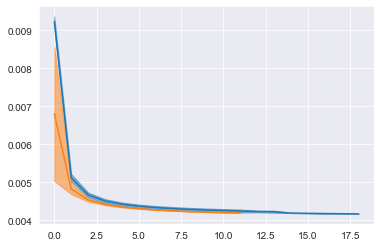

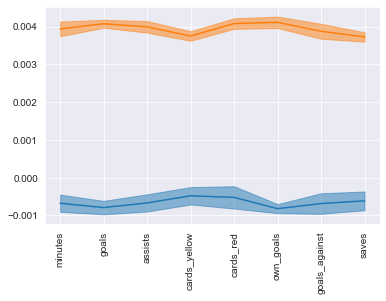

   goals  assists  cards_yellow  cards_red  own_goals  goals_against  saves
0      1        0             1          0          0              1      3
1      1        1             1          0          0              1      3
   goals  assists  cards_yellow  cards_red  own_goals  goals_against  saves
0      1        1             4          1          0              0      2
1      0        0             1          0          0              1      1


In [145]:
 config = {
        "num_layers": 3,
        "num_nodes_in": inp.shape[1],
        "num_nodes": inp.shape[1]/4,
        "num_nodes_out": out.shape[1], 
        "final_activation" : None,
        "activation": nn.LeakyReLU(),
        "clip": False, #hp.choice('clip',[True, False]),
        "batch_size": 32, #[16, 32, 64, 128]
        "loss_f": log_cosh_loss,#WSE,#hp.choice('loss_f',[WSE, nn.MSELoss()]), #, nn.L1Loss()
        "optim": 'adam',#hp.choice('optim',['adam', 'adagrad']),
        "lr": 0.0001,#hp.choice('lr',[0.0001,0.001,.00001]),#hp.loguniform('lr', np.exp(np.log(1e-4)), np.exp(np.log(1e-1))),
        "batch_norm": False,#hp.choice('batch_norm',[True, False]),
        "dropout": 0.0,#hp.choice('dropout',[0.0,0.1,0.2,0.3]),#hp.sample_from(lambda _: np.random.uniform(low=0.0, high=.6)),
        "shuffle": True,
        "num_workers": 4,
        "patience": 5,
        "epochs": 100
    }
    
lst1s, nt, errs, abserrs=runKfold([inp, out], Net, config)

print((nt(torch.Tensor(inp)).detach().cpu().numpy()[1]-nt(torch.Tensor(inp)).detach().cpu().numpy()[10]).sum())
print((nt(torch.Tensor(inp)).detach().cpu().numpy()[50]-nt(torch.Tensor(inp)).detach().cpu().numpy()[60]).sum())
print((nt(torch.Tensor(inp)).detach().cpu().numpy()[100]-nt(torch.Tensor(inp)).detach().cpu().numpy()[110]).sum())


#lsmea=[np.mean(lst1s[0],axis=0),np.mean(lst1s[1],axis=0)]
#lsstd=[np.std(lst1s[0],axis=0),np.std(lst1s[1],axis=0)]
lsmea=[[],[]]
lsstd=[[],[]]
lsmea[0],lsstd[0] = tolerant_mean(lst1s[0])
lsmea[1],lsstd[1] = tolerant_mean(lst1s[1])

plt.fill_between(np.arange(len(lsmea[0])),lsmea[0]+lsstd[0],lsmea[0]-lsstd[0], alpha=.5, color='#1f77b4')
plt.plot(lsmea[0], color='#1f77b4')
plt.fill_between(np.arange(len(lsmea[1])),lsmea[1]+lsstd[1],lsmea[1]-lsstd[1], alpha=.5, color='#ff7f0e')
plt.plot(lsmea[1], color='#ff7f0e')
plt.show()

plt.fill_between(np.arange(len(errs[0])),errs[0]+errs[1],errs[0]-errs[1], alpha=.5, color='#1f77b4')
plt.plot(errs[0], color='#1f77b4')
plt.fill_between(np.arange(len(abserrs[0])),abserrs[0]+abserrs[1],abserrs[0]-abserrs[1], alpha=.5, color='#ff7f0e')
plt.plot(abserrs[0], color='#ff7f0e')
plt.xticks(np.arange(len(errs[0])),['minutes','goals','assists','cards_yellow','cards_red','own_goals']+['goals_against','saves'], rotation=90)
plt.show()

pred=nt(torch.Tensor(inp)).detach().cpu().numpy()

i=1000
cats=['minutes','goals','assists','cards_yellow','cards_red','own_goals']+['goals_against','saves']

reframe, byteamframe = revert_output(pred[i])
print(byteamframe.astype(int))
reframe, byteamframe = revert_output(out[i])
print(byteamframe.astype(int))

In [ ]:
# do ensemble (with bagging? feature bagging too?)
